In [1]:
# CODE FOR plotting ens spread in model year 2011



import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit

@jit()
def rms(true,prediction):
    return np.sqrt(np.nanmean((prediction-true)**2))

@jit()
def rms_tendency(variable,hours):
    variable_tendency = np.zeros((hours))
    variable = np.exp(variable) * 1000.0

    for i in range(hours):
        variable_tendency[i] = np.sqrt(np.mean((variable[i+1] - variable[i])**2.0))

    return variable_tendency

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true

    weights = np.cos(np.deg2rad(lats))

    weights2d = np.zeros(np.shape(diff))

    diff_squared = diff**2.0
    #weights = np.ones((10,96))

    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)

    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)

    return np.sqrt(weighted_average)

# Define: Initial FILES, dates, Variable, and Level desired

analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/mean.nc'

analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_3_1_3_20110101_20110529_retry/mean.nc'

spread_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/sprd.nc'

spread_file_hybrid =  '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_3_1_3_20110101_20110529_retry/sprd.nc'

start_year = 2011
end_year = 2011

startdate = datetime(2011,1,1,0)
enddate = datetime(2011,5,31,0)
time_slice = slice(startdate,enddate)

level = 0.95 #0.2#0.95#0.51
level_era = 7 #2#7 #4

var_era = 'Temperature'#'Specific_Humidity'#'Temperature' #'V-wind'
var_da =  't'#'q'#'t'#'v'
print('you selected for variable =',var_era)
print('at level =',level)
timestep_6hrly = 6


# create empty list to store indiviudal datasets
era5sets = []
print('made it to the for loop...')

# LOAD DATA HERE 
print('LOADING DATA...')

# loop over the range of years and open each ds
for year in range(start_year, end_year + 1):
    nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
    # only load var_era selected and only load level_era selected from above
    ds_nature = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)
    # Read in every 6th timestep
    ds_nature = ds_nature.isel(Timestep=slice(None, None, timestep_6hrly))
    era5sets.append(ds_nature)
    
print('Now its concatinating them all together...')

ds_nature = xr.concat(era5sets, dim = 'Timestep')
ds_nature = ds_nature.sortby('Timestep')
print('Done concat and sortby Timestep...')
temp_500_nature = ds_nature.values

ds_analysis_mean = xr.open_dataset(analysis_file)[var_da].sel(lev=level,time=time_slice)
ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)[var_da].sel(lev=level,time=time_slice)

# SPREAD FILES
ds_spread_hybrid = xr.open_dataset(spread_file_hybrid)
ds_spread_speedy = xr.open_dataset(spread_file_speedy)
temp_500_analysis = ds_analysis_mean

# temp_500_analysis = ds_analysis_mean[var_da].sel(lev=level).values
temp_500_analysis_speedy = ds_analysis_mean_speedy
# temp_500_analysis_speedy = ds_analysis_mean_speedy[var_da].sel(lev=level,time=time_slice).values
temp_500_spread_hybrid = ds_spread_hybrid[var_da].sel(lev=level).values
temp_500_spread_speedy = ds_spread_speedy[var_da].sel(lev=level).values

print('era5 shape = ',np.shape(temp_500_nature))
print('speedy shape = ',np.shape(temp_500_analysis_speedy))
print('hybrid shape = ',np.shape(temp_500_analysis))

#find smallest index value to set that as the "length"
speedy_index = temp_500_analysis_speedy.shape[0]
nature_index = temp_500_nature.shape[0]
hybrid_index = temp_500_analysis.shape[0]
smallest_index = min(speedy_index,nature_index,hybrid_index)

if smallest_index == speedy_index:
    length = speedy_index #- 1
elif smallest_index == nature_index:
    length = nature_index
else:
    length = hybrid_index
print('the smallest length is',length)

#ps_nature = ds_nature['logp'].values
#ps_nature = 1000.0 * np.exp(ps_nature)
#ps_analysis = ds_analysis_mean['ps'].values/100.0

xgrid = 96
ygrid = 48
#length =365*4*2 #1952-7 # 240 for 3 months  #1450 ##338 #160#64#177#1400#455

analysis_rmse = np.zeros((length))
analysis_rmse_speedy = np.zeros((length))
global_average_ensemble_spread_hybrid = np.zeros((length))
global_average_ensemble_spread_speedy = np.zeros((length))
#ps_rmse = np.zeros((length))

analysis_error = np.zeros((length,ygrid,xgrid))
analysis_error_speedy = np.zeros((length,ygrid,xgrid))

print(np.shape(analysis_error))
print(np.shape(analysis_error_speedy))

print('Now its calculating analysis RMSE...')
lats = ds_nature.Lat
for i in range(length):
    analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis[i,:,:],lats)
    analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis_speedy[i,:,:],lats)
    #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
    analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i,:,:]
    analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i,:,:]
    global_average_ensemble_spread_hybrid[i] = np.average(temp_500_spread_hybrid[i,:,:])
    global_average_ensemble_spread_speedy[i] = np.average(temp_500_spread_speedy[i,:,:])


print('DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP')
    
# FOR DEALING WITH HOURLY RES ERA5 REANAL (((i*6)))

# for i in range(length):
#     analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i*6,:,:],temp_500_analysis[i,:,:],lats)
#     analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i*6,:,:],temp_500_analysis_speedy[i,:,:],lats)
#     #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
#     analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i*6,:,:]
#     analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i*6,:,:]
#     #global_average_ensemble_spread[i] = np.average(temp_500_spread[i,:,:])
print('Done.')

you selected for variable = Temperature
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (601, 48, 96)
hybrid shape =  (593, 48, 96)
the smallest length is 593
(593, 48, 96)
(593, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.


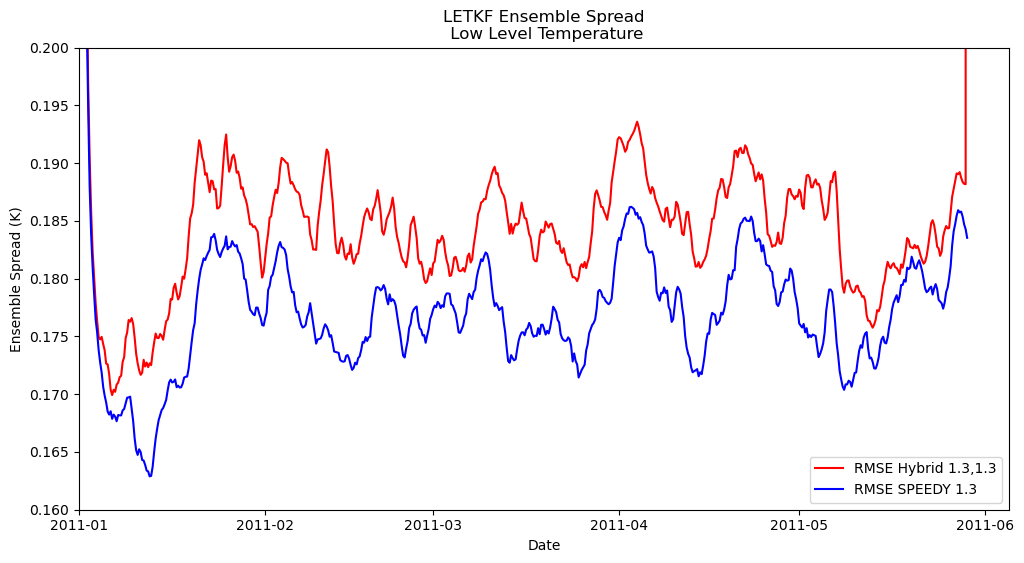

In [3]:
# code for plotting ens spread

# MAKE TIME SERIES



x = np.arange(0,length)

base = datetime(2011,1,1,0)
plt.figure(figsize=(12,6))
date_list = [base + timedelta(days=x/4) for x in range(length)]
plt.plot(date_list,global_average_ensemble_spread_hybrid,color='r',label='RMSE Hybrid 1.3,1.3') #cov-infl1.3
plt.plot(date_list,global_average_ensemble_spread_speedy,color='b',label='RMSE SPEEDY 1.3')
# plt.axhline(y=np.average(analysis_rmse[20::]), color='r', linestyle='--',label="Average RMSE Hybrid 1.5,1.3")
# plt.axhline(y=np.average(analysis_rmse_speedy[20::]), color='b', linestyle='--',label="Average RMSE SPEEDY 1.3")

#plt.plot(date_list,global_average_ensemble_spread,label='Ensemble Spread')
#plt.title('LETKF Analysis Error\n Low Level Specific Humidity')
plt.title('LETKF Ensemble Spread\n Low Level Temperature')
#plt.title('Ensemble Spread\nModel Level 4 Temperature')
plt.legend()
plt.xlabel('Date')

plt.ylabel('Ensemble Spread (K)')
plt.xlim([datetime(2011,1, 1,0), datetime(2011, 6, 5,0)])
plt.ylim(0.16,.2)
plt.show()


